In [24]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/home/bobrg/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
ya_search = pd.read_csv('Search_Russia.csv', sep=';', index_col=['Date'], dayfirst=True)

In [26]:
ya_search.columns = ['mon_share', 'mon_aud', 'dail_share', 'dail_aud', 'sear_share']

### Будем предсказывать месячную аудиторию Яндекс Поиска.

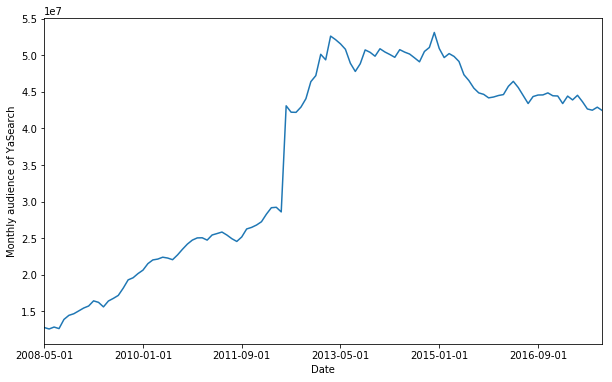

In [27]:
figsize(10,6)
ya_search.mon_aud.plot()
plt.ylabel('Monthly audience of YaSearch')
pylab.show()

In [28]:
ya_search.reset_index(inplace=True)
ya_search['Date'] = pd.to_datetime(ya_search['Date'])
ya_search = ya_search.set_index('Date')

In [29]:
ya_search.head(3)

,mon_share,mon_aud,dail_share,dail_aud,sear_share
Date,,,,,
2008-05-01,0.694468,12790940,0.327193,3722350,0.536640
2008-06-01,0.679789,12590870,0.319162,3516480,0.543052
2008-07-01,0.678226,12854750,0.320217,3439360,0.548644


In [30]:
ya_search.mon_aud = (ya_search.mon_aud)/1e7

In [31]:
ya_search.head(3)

,mon_share,mon_aud,dail_share,dail_aud,sear_share
Date,,,,,
2008-05-01,0.694468,1.279094,0.327193,3722350,0.536640
2008-06-01,0.679789,1.259087,0.319162,3516480,0.543052
2008-07-01,0.678226,1.285475,0.320217,3439360,0.548644


### Стационаризируем наш ряд.<br>
Сделаем STL-декомпозицию и оценим критерий Дики-Фуллера.

Критерий Дики-Фуллера: p=0.420472


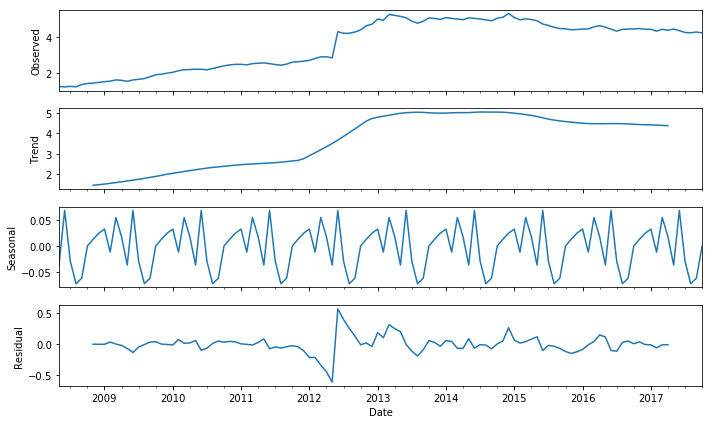

In [32]:
sm.tsa.seasonal_decompose(ya_search.mon_aud).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ya_search.mon_aud)[1])

Взглянем в добавок на графики ACF и PACF.

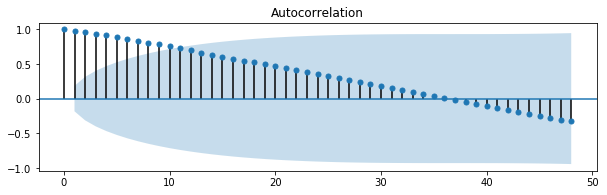

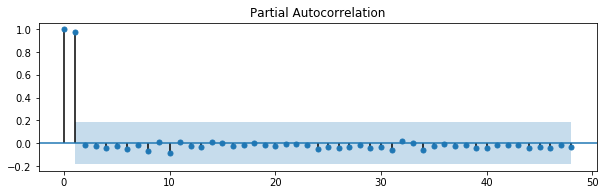

In [10]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ya_search.mon_aud.values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ya_search.mon_aud.values.squeeze(), lags=48, ax=ax)
pylab.show()

Можно сказать что сезонности в данном ряде нет, а также не замечено возрастания дисперсии.<p>
Значит хватит обычного дифференцирования ряда, чтобы сделать ряд стационарным.

Критерий Дики-Фуллера: p=0.000000


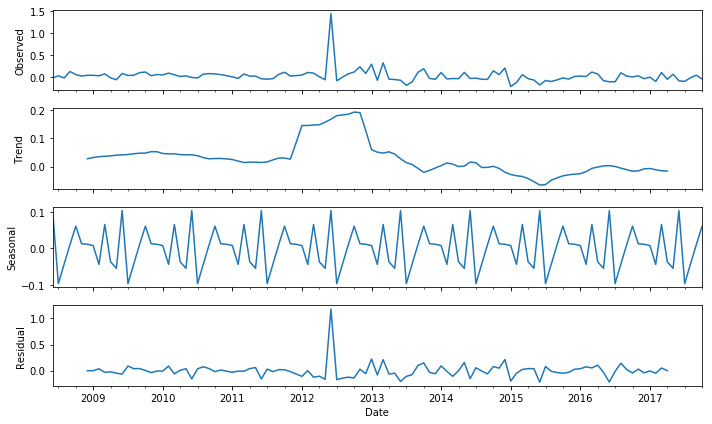

In [35]:
ya_search['mon_aud_diff'] = ya_search.mon_aud - ya_search.mon_aud.shift(1)
sm.tsa.seasonal_decompose(ya_search.mon_aud_diff[1:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ya_search.mon_aud_diff[1:])[1])

Да, критерий Дики Фуллера < 0.05, а значит ряд стационарен!

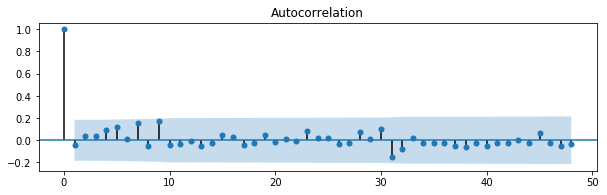

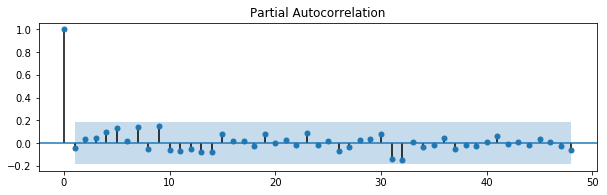

In [36]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ya_search.mon_aud_diff[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ya_search.mon_aud_diff[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()

## ARIMA <br>

### Подберем параметры для модели.

In [38]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [37]:
ps = range(0, 5)
d=1 #поскольку один раз дифференцируем ряд.
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

25

In [39]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=ARIMA(ya_search.mon_aud, order=(param[0], 1, param[1])).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    #будем сравнивать модели по aic
    aic = abs(model.aic)
    #сохраняем лучшую модель, aic, параметры
    if (aic) < (best_aic):
        best_model = model
        best_aic = (aic)
        best_param = param
    results.append([param, (model.aic)])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2)
wrong parameters: (1, 3)
wrong parameters: (1, 4)
wrong parameters: (2, 3)
wrong parameters: (2, 4)
wrong parameters: (3, 3)
wrong parameters: (3, 4)
wrong parameters: (4, 4)


In [40]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
0     (0, 0) -88.654093
5     (1, 0) -86.891124
1     (0, 1) -86.874670
6     (1, 1) -86.217214
8     (2, 1) -85.179812


In [41]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.mon_aud   No. Observations:                  113
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  47.015
Method:                       css-mle   S.D. of innovations              0.158
Date:                Fri, 15 Dec 2017   AIC                            -82.031
Time:                        23:27:02   BIC                            -65.666
Sample:                    06-01-2008   HQIC                           -75.390
                         - 10-01-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0260      0.015      1.709      0.090      -0.004       0.056
ar.L1.D.mon_aud    -0.4748      0.131     -3.632      0.000      -0.731      -0.219
ar.L2.D.mon_aud    -0.9480      0.043    -22.081      0.000      -1.032      -0.864
ma.L1.D.mon_aud     0.4797      0.099      4.830      0.000       0.285       0.674
ma.L2.D.mon_aud     1.0000      0.112      8.889      0.000       0.780       1.220
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2504           -0.9961j            1.0271           -0.2892
AR.2           -0.2504           +0.9961j            1.0271            0.2892
MA.1           -0.2398           -0.9708j            1.0000           -0.2885
MA.2           -0.2398           +0.9708j            1.0000            0.2885
-----------------------------------------------------------------------------
"""

Лучшая модель - ARIMA(2,1,2)<br>
Оценим остатки.

Критерий Стьюдента: p=0.990753
Критерий Колмогорова-Смирнова: p=0.000000
Критерий Дики-Фуллера: p=0.000000


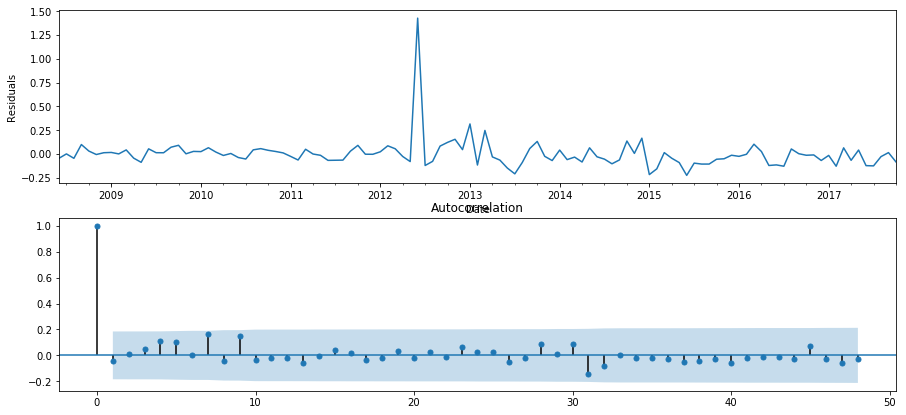

In [65]:
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Колмогорова-Смирнова: p=%f" % stats.kstest(best_model.resid.values, 'norm')[1]) # проверка на нормальность
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1]) # проверка на стационарность

Модель ARIMA выдает предсказания для продифференцированного ряда :С <br>
Поэтому нужно провести обратное преобразование прежде чем визуализировать результат.

In [57]:
predictions_ARIMA_diff = pd.Series(best_model.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2008-06-01    0.026040
2008-07-01    0.026113
2008-08-01    0.024835
2008-09-01    0.026608
2008-10-01    0.025565
dtype: float64

In [58]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(ya_search.mon_aud.iloc[0], index=ya_search.mon_aud.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)

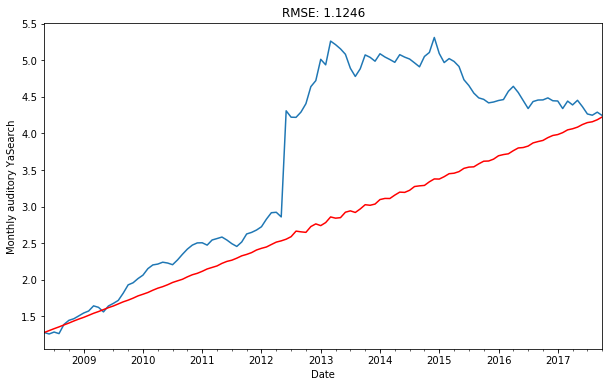

In [59]:
ya_search['mon_aud_model'] = predictions_ARIMA
ya_search.mon_aud.plot()
ya_search.mon_aud_model.plot(color='r')
plt.ylabel('Monthly auditory YaSearch')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ya_search.mon_aud)**2)/len(ya_search.mon_aud)))
pylab.show()

Для данного ряда ARIMA сделала все возможное...

Построим предсказание для продифференцированного ряда, так как на нем они будут выглядеть нагляднее.

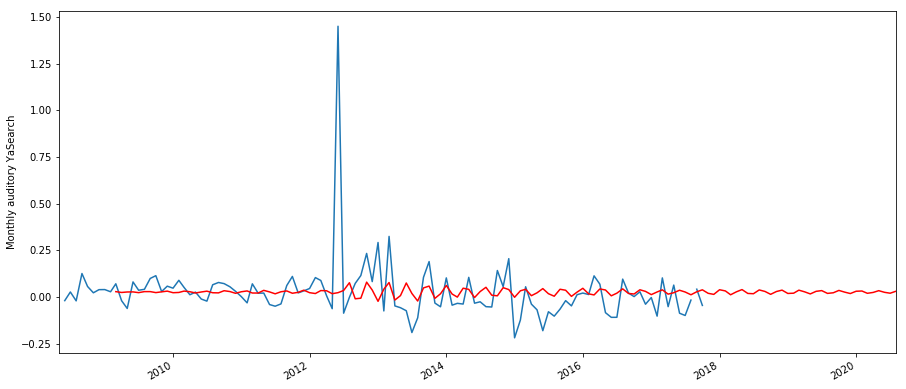

In [85]:
ya_search2 = ya_search[['mon_aud_diff']]
date_list = [datetime.datetime.strptime("2017-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= ya_search2.columns)
ya_search2 = pd.concat([ya_search2, future])
ya_search2['forecast'] = (best_model.predict(start=10, end=300))

plt.figure(figsize(15,7))
ya_search2.mon_aud_diff.plot()
ya_search2.forecast.plot(color='r')
plt.ylabel('Monthly auditory YaSearch')
pylab.show()